In [327]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [328]:
from sklearn.preprocessing import LabelEncoder 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz
import pydotplus

In [329]:
import warnings
warnings.filterwarnings('ignore')

In [330]:
%matplotlib inline

In [331]:
sns.set(rc={'figure.figsize':(15,6)})
sns.set_style(style='darkgrid')

In [332]:
retention = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_Take_Home/03Retention/employee_retention_data.csv', 
                        parse_dates=['join_date', 'quit_date'])

In [333]:
retention.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [334]:
retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24702 non-null  float64       
 1   company_id   24702 non-null  int64         
 2   dept         24702 non-null  object        
 3   seniority    24702 non-null  int64         
 4   salary       24702 non-null  float64       
 5   join_date    24702 non-null  datetime64[ns]
 6   quit_date    13510 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.3+ MB


In [335]:
retention.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


In [336]:
retention.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

## Table for `day`, `employee_headcount` and `company_id` 

In [337]:
retention.join_date.min(), retention.join_date.max()

(Timestamp('2011-01-24 00:00:00'), Timestamp('2015-12-10 00:00:00'))

In [338]:
all_date = pd.date_range(start='2011-01-24', 
                          end='2015-12-10', 
                          freq='D')

In [339]:
all_company = sorted(retention['company_id'].unique())

In [340]:
all_company

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [341]:
day = []
company_id = []
employee_headcount = []

for date in all_date: 
    for cpn in all_company: 
        day.append(date)
        company_id.append(cpn)
        tmp_joined = len(retention[(retention['company_id'] == cpn) & (retention['join_date'] <= date)])
        tmp_quited = len(retention[(retention['company_id'] == cpn) & (retention['quit_date'] <= date)])
        employee_headcount.append(tmp_joined - tmp_quited)

tab1 = pd.DataFrame({'day': day, 
                     'company_id': company_id, 
                     'employee_headcount': employee_headcount})

In [342]:
tab1.head()

,day,company_id,employee_headcount
0,2011-01-24,1,25
1,2011-01-24,2,17
2,2011-01-24,3,9
3,2011-01-24,4,12
4,2011-01-24,5,5


- Table `ret_quit` (only who once quited) and `ret_stay` (only who never quit)

In [343]:
ret_quit = retention[~retention['quit_date'].isna()]
ret_stay = retention[retention['quit_date'].isna()]

In [344]:
ret_quit.loc[:, 'stay_days'] = list(map(lambda item: item.days, ret_quit['quit_date'] - ret_quit['join_date']))
ret_quit.loc[:, 'month'] = list(map(lambda item:item.month, ret_quit['quit_date']))
ret_quit.loc[:, 'year'] = list(map(lambda item:item.year, ret_quit['quit_date']))

In [345]:
ret_quit.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,stay_days,month,year
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,10,2015
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340,4,2014
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389,6,2013
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040,8,2014
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578,8,2013


In [346]:
ret_quit.shape, ret_stay.shape

((13510, 10), (11192, 7))

- Table `tab1_month`: resample by month

In [347]:
tab1_month = tab1.copy()
tab1_month.index = pd.to_datetime(tab1_month['day'], format='%m/%d/%Y')
tab1_month = tab1_month.drop('day', axis=1)

In [348]:
tab1_month = tab1_month.groupby(by=[pd.Grouper(freq='M'), 'company_id']).max().reset_index()
tab1_month['year'] = list(map(lambda item:item.year, tab1_month['day']))
tab1_month['month'] = list(map(lambda item:item.month, tab1_month['day']))

In [349]:
tab1_month.head()

,day,company_id,employee_headcount,year,month
0,2011-01-31,1,59,2011,1
1,2011-01-31,2,31,2011,1
2,2011-01-31,3,19,2011,1
3,2011-01-31,4,18,2011,1
4,2011-01-31,5,13,2011,1


- Table `quit_tab1_month1`: join `ret_quit` and `tab1_month` 

In [350]:
quit_tab1_month = pd.merge(ret_quit, tab1_month, on=['year', 'month', 'company_id'])
quit_tab1_month = quit_tab1_month.drop('day', axis=1)
quit_tab1_month.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,stay_days,month,year,employee_headcount
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,10,2015,536
1,860900.0,7,engineer,6,165000.0,2014-10-22,2015-10-23,366,10,2015,536
2,99867.0,7,data_science,7,159000.0,2013-04-22,2015-10-16,907,10,2015,536
3,903634.0,7,engineer,11,178000.0,2011-04-04,2015-10-02,1642,10,2015,536
4,248006.0,7,marketing,14,100000.0,2014-08-25,2015-10-23,424,10,2015,536


## EDA

' The headcount of the companies have a fast growth from 2011 to 2014, while slow down gradually and level off after 2015.  '

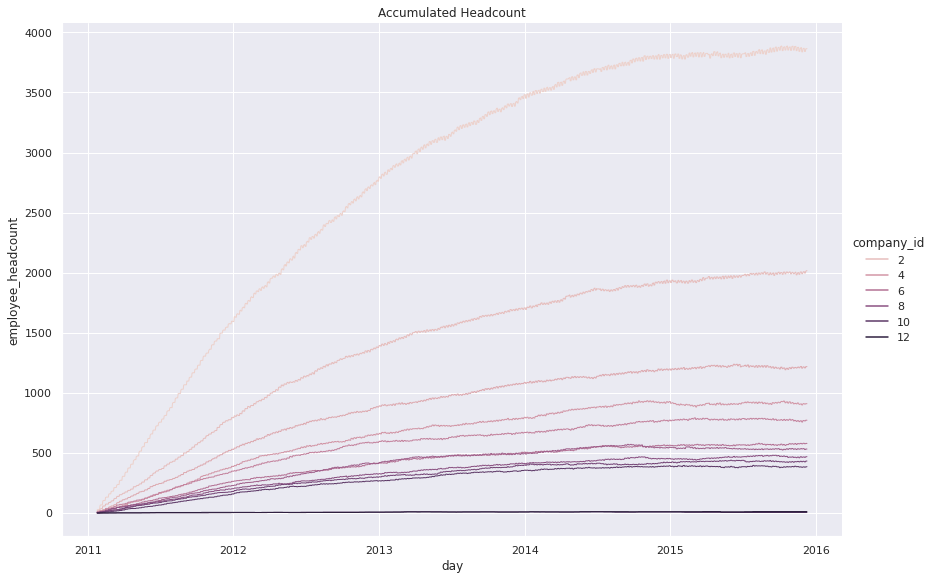

In [351]:
sns.relplot(data=tab1, x='day', y='employee_headcount', 
            kind='line', 
            hue='company_id', 
            height=8, aspect=1.5, 
            lw=1).set(title='Accumulated Headcount')

''' The headcount of the companies have a fast growth from 2011 to 2014, while slow down gradually and level off after 2015.  '''

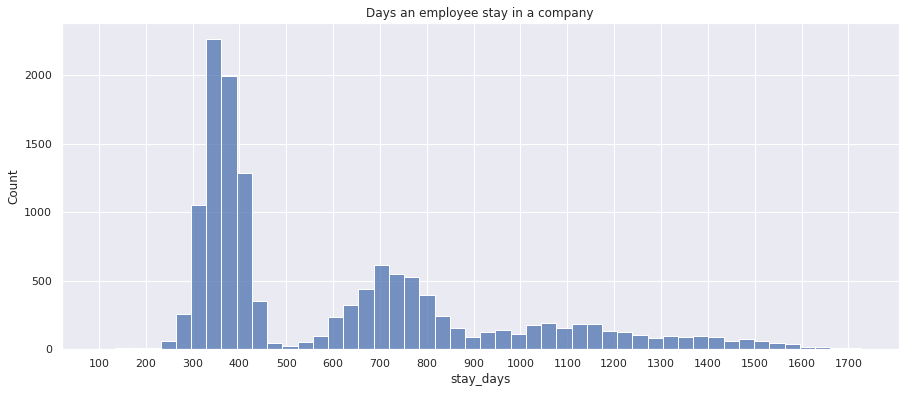

In [352]:
ht = sns.histplot(data=ret_quit, x='stay_days', 
             bins=50)
ht.set_xticks(range(100,1800,100))
ht.set_title('Days an employee stay in a company')
plt.show()

Most employees stay in the company for around 350 days (1 year). While there are another group who stay for around 700 days (2 years).

Text(0.5, 1.0, 'Number of quit in each month')

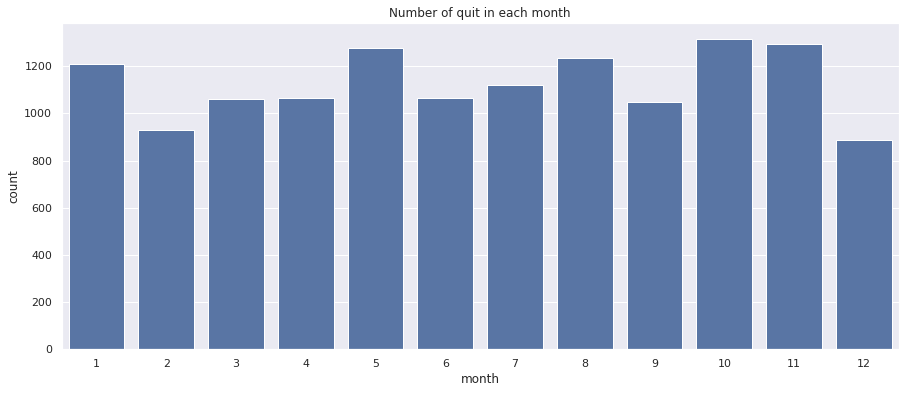

In [354]:
sns.countplot(data=ret_quit, x='month', 
              color='C0').set_title('Number of quit in each month')

Text(0.5, 1.0, 'Number of quit in each year')

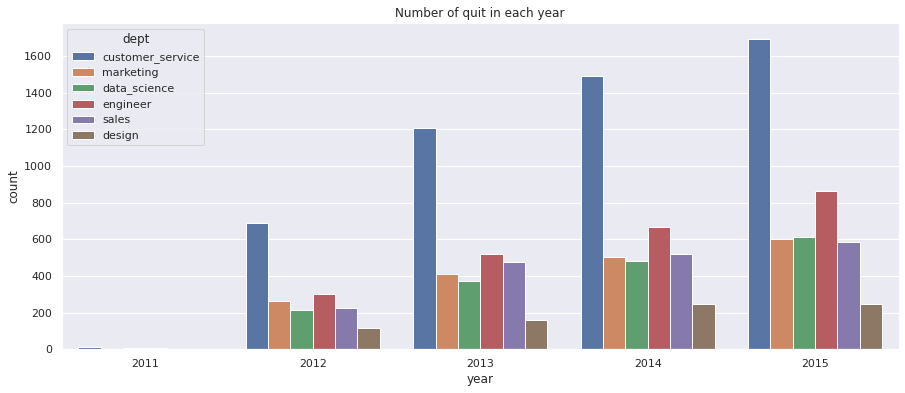

In [355]:
sns.countplot(data=ret_quit, x='year', 
              hue='dept').set_title('Number of quit in each year')

Text(0.5, 1.0, 'Number of quit in each month')

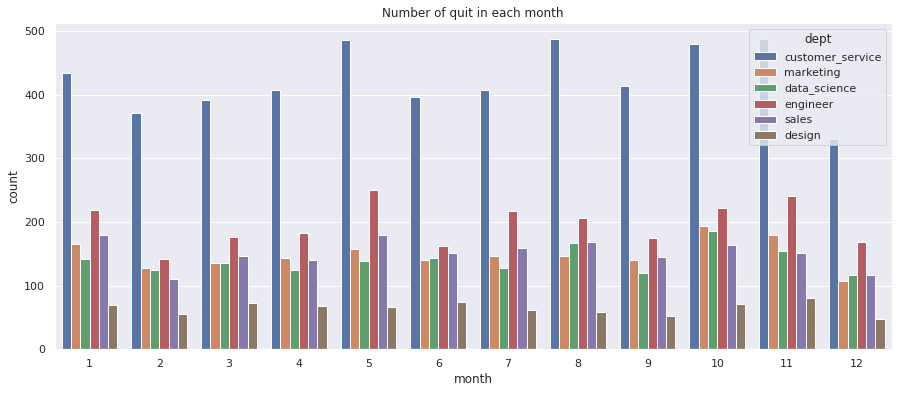

In [356]:
sns.countplot(data=ret_quit, x='month', 
              hue='dept').set_title('Number of quit in each month')

In [357]:
quit_tab1_month.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,stay_days,month,year,employee_headcount
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585,10,2015,536
1,860900.0,7,engineer,6,165000.0,2014-10-22,2015-10-23,366,10,2015,536
2,99867.0,7,data_science,7,159000.0,2013-04-22,2015-10-16,907,10,2015,536
3,903634.0,7,engineer,11,178000.0,2011-04-04,2015-10-02,1642,10,2015,536
4,248006.0,7,marketing,14,100000.0,2014-08-25,2015-10-23,424,10,2015,536


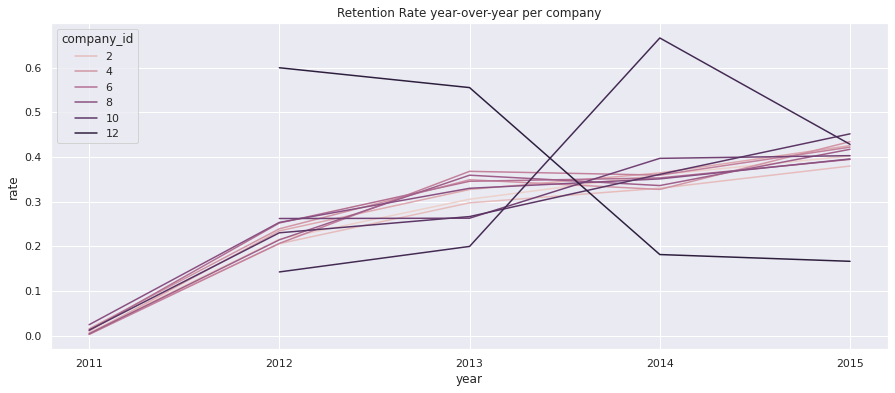

In [358]:
tmp_tab = quit_tab1_month.groupby(['year', 'company_id']).apply(lambda row: 
                                                      pd.Series({'rate':len(row) / max(row['employee_headcount'])})
                                                      ).reset_index()
lp = sns.lineplot(data=tmp_tab, x='year', y='rate', 
             hue='company_id')
lp.set_xticks(range(2011,2016,1))
lp.set_title('Retention Rate year-over-year per company')
plt.show()

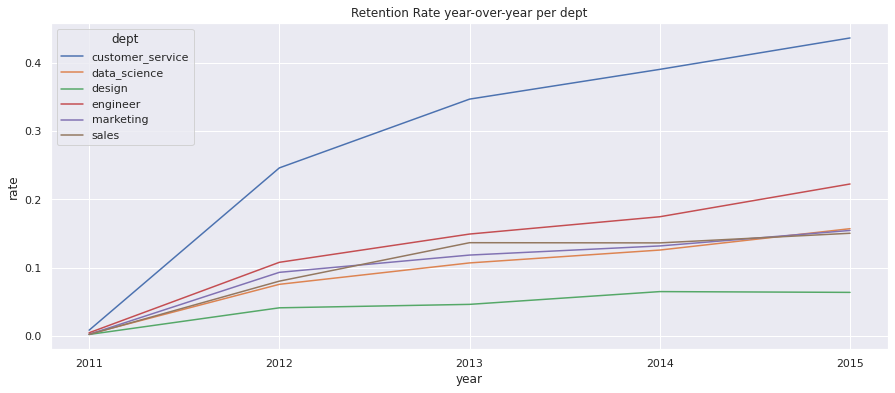

In [359]:
tmp_tab = quit_tab1_month.groupby(['year', 'dept']).apply(lambda row: 
                                                      pd.Series({'rate':len(row) / max(row['employee_headcount'])})
                                                      ).reset_index()
lp = sns.lineplot(data=tmp_tab, x='year', y='rate', 
             hue='dept')
lp.set_xticks(range(2011,2016,1))
lp.set_title('Retention Rate year-over-year per dept')
plt.show()

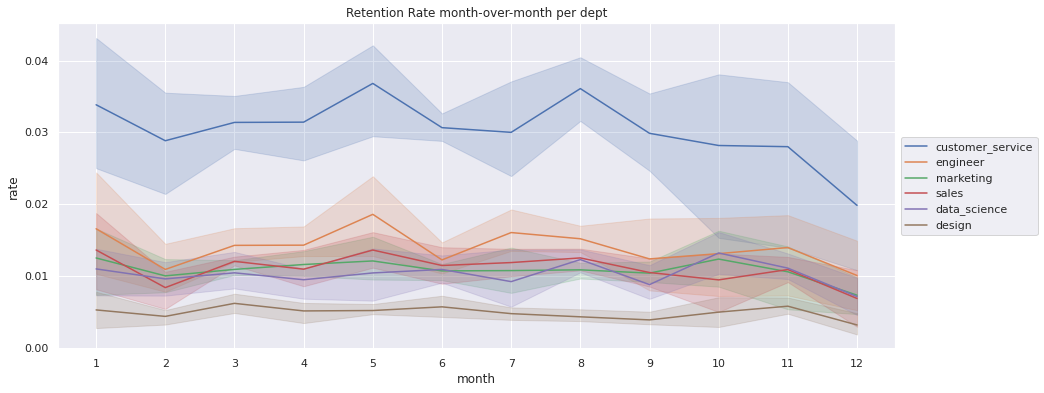

In [360]:
tmp_tab = quit_tab1_month.groupby(['year', 'month', 'dept']).apply(lambda row: 
                                                      pd.Series({'rate':len(row) / max(row['employee_headcount'])})
                                                      ).reset_index()
lp = sns.lineplot(data=tmp_tab, x='month', y='rate', 
             hue='dept')
lp.set_xticks(range(1,13,1))
lp.set_title('Retention Rate month-over-month per dept')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.show()

In [361]:
retention

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
...,...,...,...,...,...,...,...
24697,549847.0,3,customer_service,16,97000.0,2015-02-18,NaT
24698,590087.0,4,engineer,10,160000.0,2015-10-26,NaT
24699,777612.0,4,customer_service,11,67000.0,2013-09-03,2015-10-23
24700,97289.0,10,engineer,98,266000.0,2011-12-13,2015-01-09


In [362]:
sub_retention = retention[retention['join_date'] < (np.datetime64('2015-12-10') - 365)]

In [363]:
sub_retention.shape, retention.shape

((19655, 7), (24702, 7))

In [364]:
sub_retention.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [365]:
tmp2 = sub_retention.copy()
tmp2['bin_salary'] = pd.qcut(sub_retention['salary'], 25)

In [366]:
def days(row): 
    item = np.datetime64('2015-12-10') - row['join_date'] if row['quit_date'] is pd.NaT  else row['quit_date'] - row['join_date']
    return item.days
tmp2['stay_days'] = tmp2.apply(days, axis=1)

In [367]:
tmp2.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,bin_salary,stay_days
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,"(85000.0, 92000.0]",585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,"(179000.0, 191000.0]",340
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,"(99000.0, 106000.0]",423
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,"(112000.0, 119000.0]",389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,"(266000.0, 299000.0]",1040


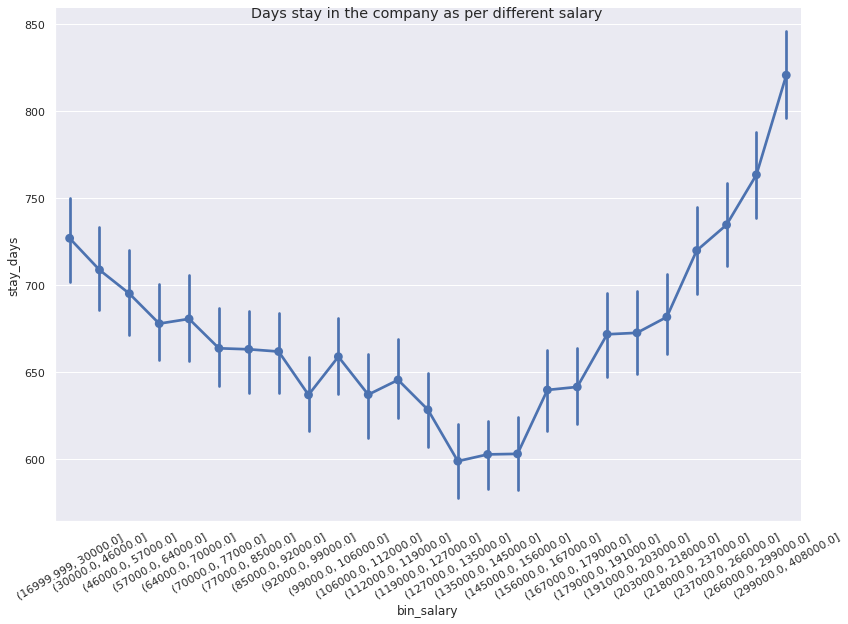

In [371]:
cp = sns.catplot(data=tmp2, x='bin_salary', y='stay_days', 
                 kind='point', 
                 alpha=0.4,
                 height=8, aspect=1.5)
cp.fig.suptitle('Days stay in the company as per different salary')
cp.set_xticklabels(rotation=30)
plt.show()

# Modelling

In [372]:
quit_1year = (sub_retention['quit_date'] < sub_retention['join_date'] + pd.DateOffset(days=365))
sub_retention['quit_1year'] = quit_1year.astype(int)

In [373]:
sub_retention.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_1year
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,0


In [374]:
X = sub_retention[['company_id', 'dept', 'seniority', 'salary']]
Y = sub_retention[['quit_1year']]

In [375]:
LE = LabelEncoder()
X['dept'] = LE.fit_transform(X['dept'])

In [376]:
X.head()

,company_id,dept,seniority,salary
0,7,0,28,89000.0
1,7,4,20,183000.0
2,4,4,14,101000.0
3,7,0,20,115000.0
4,2,1,23,276000.0


In [377]:
clf = DecisionTreeClassifier(max_depth=len(X.columns), min_samples_leaf=len(X)//100)
clf.fit(X, Y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=196)

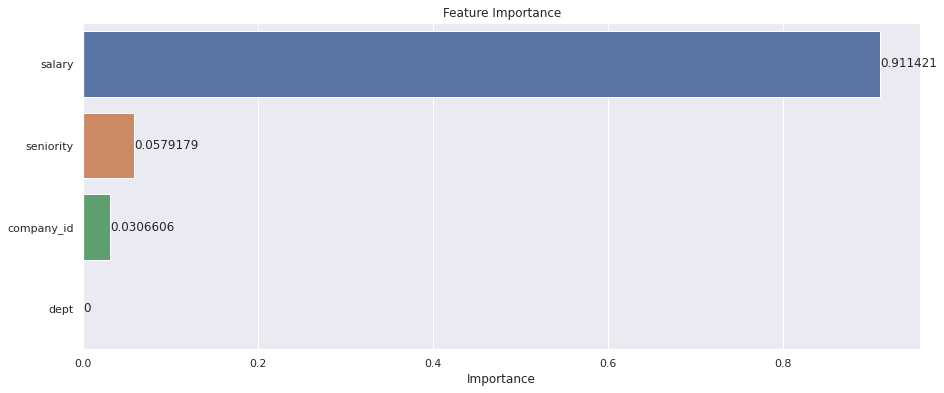

In [378]:
ft_imp = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)
bp = sns.barplot(data=ft_imp, x='Importance', y=ft_imp.index)
bp.set_title('Feature Importance')
bp.bar_label(bp.containers[0])
plt.show()

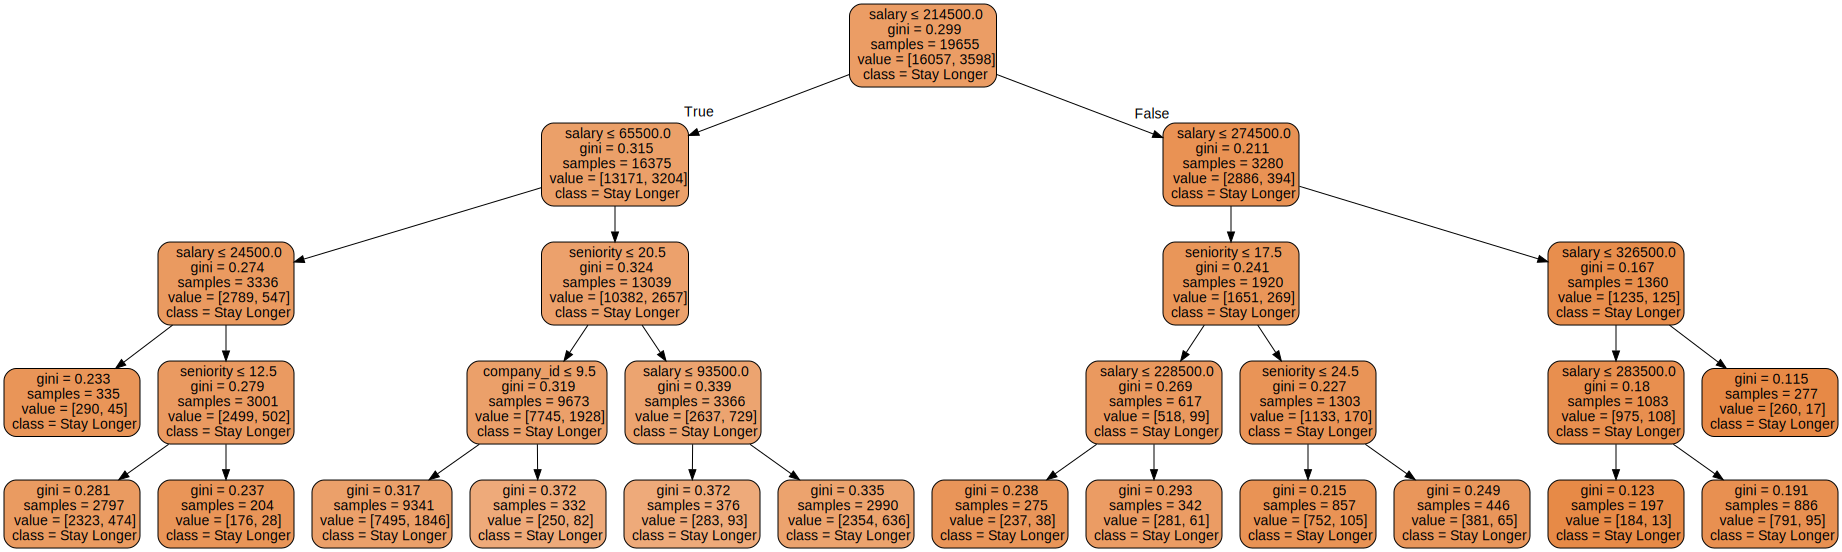

In [379]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=['Stay Longer', 'Quit in 1 year'], 
                                filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.set_size('"5,5!"')
# graph.write_png('tree.png')


Key takeaways: 
1. `Salary` is an extremely important factor related to employee churn. If possible, I'd like to know the difference before and after job-hopping. 
2. There are several peaks of churn that are January, May and August, and a groove around December. That makes sense, as people don't want to lose the year-end-bonus. 
3. People with relatively low salary and high salary tend to stay longer in the company, which indicates those people are less competitive or have higher positions in the company. 
4. The factors related to work satisfaction are not enough in our data, that's a reason why `salary` explains such a high importance. 